In [37]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
import pandas as pd

import re
import string
from spellchecker import SpellChecker

from prettytable import PrettyTable

In [266]:
import urllib.request, json 
with urllib.request.urlopen("https://raw.githubusercontent.com/taivop/joke-dataset/master/wocka.json") as url:
    raw_json = json.load(url)

all_jokes = pd.json_normalize(raw_json)

In [273]:
all_jokes.category.unique()

array(['Animal', 'Other / Misc', 'Bar', 'One Liners', 'Puns', 'Lawyer',
       'Sports', 'Medical', 'News / Politics', 'Men / Women', 'Gross',
       'Blond', 'Yo Momma', 'Redneck', 'Religious', 'At Work', 'College',
       'Lightbulb', 'Children', 'Insults', 'Knock-Knock', 'Tech',
       'Yo Mama', 'Blonde'], dtype=object)

In [392]:
all_jokes[all_jokes.category=='Tech']

,body,category,id,title
106,Tech Support \r\n\r\nJust in case you think y...,Tech,114,"Oh, My, God"
107,I called a company and asked to speak to Bob. ...,Tech,115,Stories From the Crypt
110,A programmer was crossing a road one day when ...,Tech,118,Programmer and a Princess
113,This is a true story from the WordPerfect help...,Tech,121,WordPerfect Assistant
165,How is a computer like an air conditioner? \r\...,Tech,175,Computer vs. Air Conditioner
...,...,...,...,...
9891,I think my smartphone is broken. I keep pressi...,Tech,18054,My Smartphone
9944,"Register lots of accounts, with each account v...",Tech,18117,How to Ruin a Joke on Wocka
9987,Why did the computer get sick?\r\nHe left his ...,Tech,18167,BRRRR....
9992,Long ago I gave my kid an iPod.\r\nLast year h...,Tech,18173,So Many Products


In [301]:
# filter to just the 'one liners' category of jokes
pd_jokes = all_jokes[all_jokes.category.isin(['One Liners', 'Puns', 'Knock-Knock', 'Children', 'Bar',
                                                'Lightbulb', 'Tech', 'Sports', 'Lawyer', 'At Work'])]

In [302]:
raw_jokes = [j.lower() for j in pd_jokes.body] ##convert to lowercase

# remove some specific jokes which are gibberish, seem offensive, or just not useful
remove = [
    [j for j in raw_jokes if 'ã' in j][0],
    [j for j in raw_jokes if '~' in j][0],
    [j for j in raw_jokes if '1) a clear concience' in j][0],
    [j for j in raw_jokes if "the following were some comments made in the year 1957" in j][0],
    [j for j in raw_jokes if "mcdonalds drive thru" in j][0],
    [j for j in raw_jokes if "what's an innunedo" in j][0],
    [j for j in raw_jokes if "a total waste" in j][0],
    [j for j in raw_jokes if "a word involving four letters" in j][0],
    [j for j in raw_jokes if "jkfsh" in j][0],
    [j for j in raw_jokes if 'george bush' in j][0],
    [j for j in raw_jokes if 'http' in j][0],
]
for r in remove: raw_jokes.remove(r)

In [303]:
# Deal with some specialinecases before more generalineprocessing
# Select the string that is the long lists of jokes and remove that from the corpus of jokes
special_cases = ["42.7", "getting married is very much", "an aspirin", "a hooker", "onomatopoeia", 
                "time to keep your mouth shut", "first instinct"]
cleaner_raw_jokes = raw_jokes
longjokes_list = []
for case in special_cases:
    longjoke = [j for j in raw_jokes if case in j][0] ##select
    longjokes_list.append(longjoke) ##save string to list
    cleaner_raw_jokes = [j for j in cleaner_raw_jokes if case not in j] ##remove from cleaner jokes corpus

# Deal with a special case within the special cases (the last case in the special cases list)
l_firstinstinct = longjokes_list[len(longjokes_list)-1].splitlines()
for i, l in enumerate(l_firstinstinct):
    if "----" in l: l_firstinstinct[i] = "<S>"

l_list = []
current_joke = ""
for line in l_firstinstinct:
    if line == "<S>":
        current_joke = re.sub(',', ', ', current_joke)
        l_list.append(current_joke)
        current_joke = ""
    else:
        current_joke += line
for j in l_list: cleaner_raw_jokes.append(j)


# Split the joke-lists strings into separate jokes and append each individual joke back to the joke corpus
for longjoke in longjokes_list[:-1]:
    for j in longjoke.splitlines(): cleaner_raw_jokes.append(j)

In [381]:
def clean_the_jokes(raw_jokes_list: list, spell_checker: SpellChecker=None,
                    min_joke_length: int=0, max_joke_length: int=100, 
                    leave_punctuation: str=""):
    """
    Clean and prepare each joke. Only saves the joke if it is greater than min_joke_length and less than max_joke_length.
    Removes all punctuation except for any specified in leave_punctuation. For example, leave_punctuation=".?" leaves periods and 
    question marks.
    """
    # 1. Initial cleaning phase
    printable = set(string.printable) #set of printable chars
    punct = set([p for p in string.punctuation if p not in "<>'" and p not in leave_punctuation]) #set of punctuation chars to remove

    # Iterate through each line (after splitting lines) and clean up characters
    cleaned_lines = []
    for j in raw_jokes_list:
        j = j +" <S>" ##add stop character to end of line
        lines = j.splitlines()
        for l in lines:
            l = ''.join([c for c in l if c not in string.whitespace[1:]]) ##remove any whitespeace chars other than space ' '
            l = ''.join([c for c in l if c in string.printable]) ##remove non-printable chars
            for p in punct:
                l = re.sub(f"\{p}", " ", l)
            # l = ''.join([c for c in l if c not in punct]) ##remove punctuation except for excpetions and special chars
            for p in leave_punctuation: 
                ##remove duplicates of any left punctuations
                l = re.sub(f"\{p}+", f"{p}", l)
                ##ensure proper spacing
                l = re.sub(f"\{p}", f" {p} ", l)
            l = l.replace(" q ", " ") ##remove q from Q&A style jokes
            repls = [] ##pad numbers with spaces so they are individual 'words'
            for digit in range(10):
                repls.append((str(digit), " "+str(digit)+" "))
                l = l.replace(*repls[digit])
            l = re.sub(' +', ' ', l) ##remove repeated spaces

            # filter out unwanted list elements - if it is blank, just spaces, or just <S>
            if (l=='') | (l==' ') | ("".join([c for c in l if c not in string.whitespace]) == "<S>"):
                pass
            else: 
            # otherwise add to list of cleaned lines
                cleaned_lines.append(" "+l)
    ## not perfect strategy since the text has inconsistent \r\n behavior - some jokes are cut into pieces, some lines are many jokes...

    # 2. Now concatenate lines into jokes based on the stop character
    final_punct = set([p for p in string.punctuation if p not in leave_punctuation])

    jokes = []
    current_joke = ""
    for line in cleaned_lines:
        while True:
            # Append lines to the current joke until the special stop <S> character is reached 
            current_joke = current_joke + line
            last_chr = line[-3:]
            if last_chr=='<S>':
                # if the last 3 characters in the line are <S>, this is the end of the joke and we should send the full joke to the list
                # First check that the joke is within the acceptable length (otherwise we throw it out)
                if min_joke_length < len(current_joke.split())-1 < max_joke_length:
                    current_joke = current_joke.replace(" <S>", "") ##remove special char
                    for b in "<>": ##remove any missed brackers
                        current_joke =  re.sub(f"\{b}", "", current_joke)
                    current_joke = re.sub(' +', ' ', current_joke) ##remove repeated spaces

                    # SPELL CHECK
                    ## Split joke into individual words. Check if any word is not in the spell-check corpus
                    ## If not, replace the word with its most likely correction (unless spell checker returns None)
                    split_joke = current_joke.split()
                    if spell_checker is not None:
                        for ix, word in enumerate(split_joke): 
                            if word not in spell_checker:
                                correction = spell_checker.correction(word)
                                if correction is not None:
                                    split_joke[ix] = correction
                    ## Recombine the words into one string
                    final_joke = ' '.join(split_joke)
                    # Check some special cases that lead to annoyances in the training data
                    if (' ? a ' in final_joke) and (final_joke[0]=='i'): ##(a particular joke format follows: i a silly question ? a a witty answer)
                        j = final_joke.split('?') ##split on the '?' in the middle of the joke
                        j1, j2 = j[0], j[-1] ##keep the outside vectors if more than 2 '?'s existed
                        final_joke = '? '.join([j1[1:], j2[2:]]) ##crop off the 'i' and 'a' chars that precede the string we care about, add back '?'
                    if final_joke[0:2] == 'q ': final_joke = final_joke[2:] ##remove any lonely 'q's (from Q: a question type jokes)
                    ## Finally append to output joke list
                    jokes.append(final_joke)          
                current_joke = "" ##reset current joke to empty str
                break
            else: 
                #otherwise continue appending lines to this current joke
                break

    return jokes

In [382]:
def remove_bad_jokes(list_o_jokes : list, remove_words : list):
    """Remove some jokes that are insensitive, badly worded, etc..."""
    jokes = []
    for joke in list_o_jokes:
        if any(w in joke for w in remove_words):
            pass
        else:
            jokes.append(joke)
    
    return jokes

In [404]:
# Init spellchecker
spellcheck = SpellChecker()

# Clean the raw jokes (pass in the spellchecker)
jokes = clean_the_jokes(cleaner_raw_jokes, spellcheck, 
                        min_joke_length= 10, max_joke_length=40,  ##majority of jokes are in this word range
                        leave_punctuation="?")

# Remove jokes containing some insensitive topics (these are some bad webscraped jokes...)
remover_string = ['retard', ' rape', ' porn', ' bitch', ' condom', ' dick', ' cum', ' tits', 'fuck']
jokes = remove_bad_jokes(jokes, remover_string)


print(f"{len(jokes) = }")
print(f"{min(jokes, key=len) = }")
print(f"{max(jokes, key=len) = }")



len(jokes) = 1432
min(jokes, key=len) = " what's a pick up line in a gay bar ? "
max(jokes, key=len) = 'the democratic national committee finally released thousands of pages of financial disclosure information says vince vieceli unfortunately they released them from a third floor balcony in new york during the parade for the yankees'


## Save jokes to a text file

In [405]:
with open('jokes.txt', 'w') as f:
    for line in jokes:
        f.write(f"{line}\n")

---

In [406]:
words = set(' '.join([j for j in jokes]).split(' '))
words = [w for w in words if w != ""] ##remove empty string
len(words)

4339

In [407]:
chars = sorted(list(set(''.join(jokes)))) 
stoi = {s:i+1 for i, s in enumerate(chars)} ##create dictionary mapping from char to int
stoi['.'] = 0 ##add special start/end character
itos = {i:s for s, i in stoi.items()}

len(chars)

39

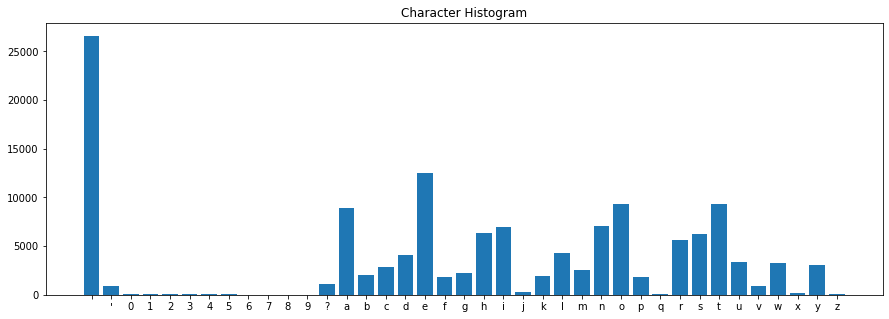

In [408]:
corpus = ''.join(jokes)
count_letters = dict()

for c in chars:
    count_letters[c] = corpus.count(c)

plt.figure(figsize=(15,5))
plt.bar(range(len(count_letters)), list(count_letters.values()), align='center')
plt.xticks(range(len(count_letters)), list(count_letters.keys()))
plt.title("Character Histogram")
plt.show()

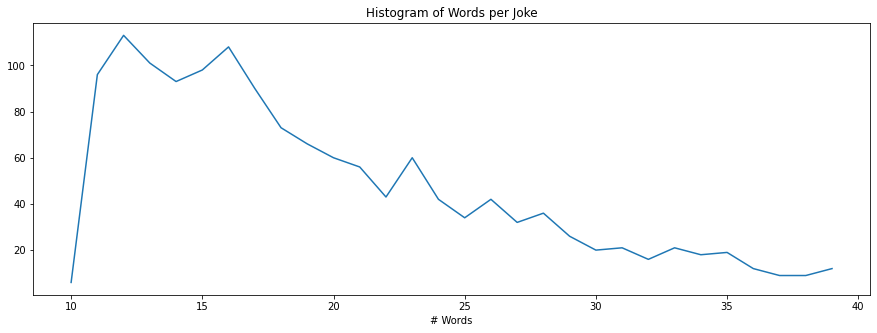

In [403]:
joke_length = {k: 0 for k in range(100)}
for j in jokes:
    length = len(j.split(" "))
    joke_length[length] += 1
joke_length = {k:v for k,v in joke_length.items() if v>0}

plt.figure(figsize=(15,5))
plt.plot(list(joke_length.keys()), list(joke_length.values()))    
plt.title("Histogram of Words per Joke")
plt.xlabel("# Words")
plt.show()